# Kaggle competition

New Data available, in different format so we need to repreprocess everything

# 0 - Imports

In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

from xgboost import XGBClassifier
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, ClassifierMixin

c:\Users\Louis\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# I - Data Preprocessing

<div style="
    padding: 15px;
    border: 2px solid #bee5eb;
    border-radius: 5px;
    background-color: #d1ecf1;
    color: #0c5460;
    font-size: 14px;
    margin-bottom: 10px;
    line-height: 1.5;
    max-width: 1125px;">
    <strong>ℹ️ Data Processing:</strong>
    <p>
    Although the initial dataset is of sufficient quality, augmenting the dataset did lead to some <b>type inconsistencies</b>, hence the .astype() functions.
    Additionally, I erased the 'blanks' row, since I did not want to train a model to predict nothing, which would only decrease accuracy.
    </p>
</div>

In [2]:
# df_train = pd.read_csv('Lexical_juggling_train.csv')
# df_train = pd.read_csv('train_submission.csv')
df_train = pd.read_excel('train_augmented.xlsx', sheet_name='Data')
df_train.dropna(subset=['Label'], inplace=True)
labels_with_multiple_rows = df_train['Label'].value_counts()
labels_to_keep = labels_with_multiple_rows[labels_with_multiple_rows > 1].index
df_train = df_train[df_train['Label'].isin(labels_to_keep)]
df_train['Text'] = df_train['Text'].astype(str)
df_train['Label'] = df_train['Label'].astype(str)
df_train.head(2)

,Text,Label
0,Finalment Atena le recibe en l'acropoli d'Ate...,arg
1,Jane Laffort fille de Joseph Laffort et d' Ang...,lat


In [3]:
df_test = pd.read_csv('test_without_labels.csv')
df_test.head(2)

,Usage,Text
0,Private,Hüttwilen el xe on comune del Canton Turgovia ...
1,Private,La leĝo zorgas pri kompenso de nur la plej gra...


In [4]:
print("Train Shape = ",df_train.shape)
print("Test shape = ",df_test.shape)
print("List labels length = ", len(df_train['Label'].unique()))
# print(df_train['Label'].unique())

Train Shape =  (41149, 2)
Test shape =  (190567, 2)
List labels length =  385


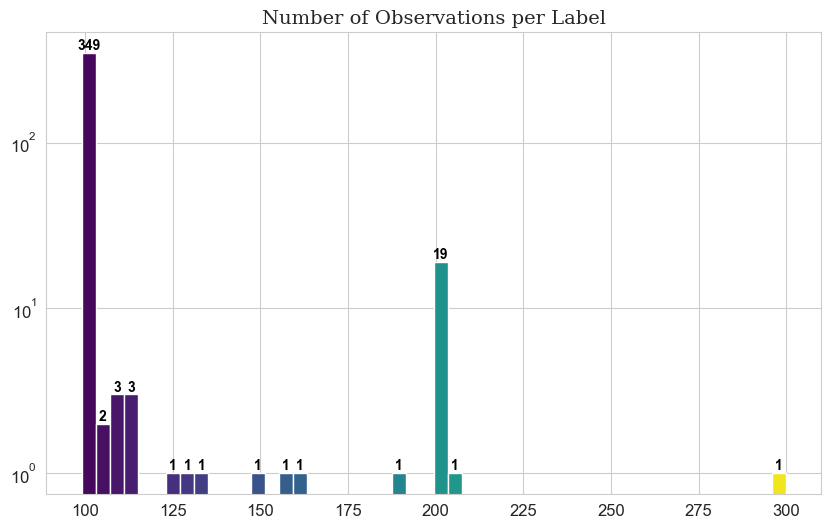

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style("whitegrid")

label_counts = df_train['Label'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
colors = sns.color_palette("viridis", 50)
n, bins, patches = plt.hist(label_counts, bins=50, color=colors[-1])

for i, patch in enumerate(patches):
    patch.set_facecolor(colors[i % len(colors)])

for i, patch in enumerate(patches):
    patch.set_facecolor(colors[i % len(colors)])

    if n[i] > 0:
        plt.text(patch.get_x() + patch.get_width() / 2, n[i], f"{int(n[i])}", 
                 ha='center', va='bottom', fontsize=10, fontweight='bold', color='black')


plt.yscale('log')

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title("Number of Observations per Label", fontsize=14, fontname='serif')

plt.show()


<div style="border-left: 5px solid green; padding-left: 10px;">As such, we have <b>38K sentences</b> in different languages, to classify in 390 categories. We assume that each label refers to a language, though the exact semantic is not relevant for the classification. The classes were initially unbalanced. To solve the class imbalance, we decided to proceed with <b>data augmentation</b> (oversampling to be accurate) and generate "train_augmented.xlsx" through a mix of gpt2 (initially), and then queries with chatgpt-o1-mini for quality's sake.</div>

In [6]:
df_lab = pd.DataFrame(df_train)

label_counts = df_lab["Label"].value_counts().reset_index()
label_counts.columns = ["Label", "Count"]
# Simple print to make sure that each label possesses at least 100 observations (ceb was missed by one but don't mind it, I forgot one example)
print(label_counts)

    Label  Count
0     tgk    300
1     teo    205
2     wbm    203
3     hin    200
4     tat    200
..    ...    ...
380   xho    100
381   yao    100
382   hus    100
383   kau    100
384   ceb     99

[385 rows x 2 columns]


# II - Baseline Model

## 0 -  Character + Word N-Gram TF-IDF + Logistic Regression

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer

class TqdmTfidfVectorizer(TfidfVectorizer):
    def fit_transform(self, raw_documents, y=None):
        raw_documents = list(tqdm(raw_documents, desc="TFIDF Fit Transform"))
        return super().fit_transform(raw_documents, y)
    def transform(self, raw_documents):
        raw_documents = list(tqdm(raw_documents, desc="TFIDF Transform"))
        return super().transform(raw_documents)

# Defining'Text' as X since this will be the data available and 'Label' as Y as we need to classify, hence it is our 'Prediction'
X = df_train['Text']
y = df_train['Label']

# Split in 80/20, sampled randomly while keeping class balance in both train and test sets, using the argument 'stratify' based on labels.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.01, stratify=y, random_state=42
)

In [8]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='char_wb', ngram_range=(3, 6), max_features=200000)),
    ('clf', LogisticRegression(solver='saga', max_iter=50, verbose=2))
])
pipeline.fit(X_train, y_train)
# y_pred = pipeline.predict(X_test)
y_pred = pipeline.predict(df_test['Text'])
# print(classification_report(y_test, y_pred))

convergence after 22 epochs took 451 seconds


Other baselines

### II.1 - Logistic Regression

<div style="
    padding: 15px;
    border: 2px solid #bee5eb;
    border-radius: 5px;
    background-color: #d1ecf1;
    color: #0c5460;
    font-size: 14px;
    margin-bottom: 10px;
    line-height: 1.5;
    max-width: 1125px;">
    <strong>ℹ️ Pipeline Description:</strong>
    <p>
    The baseline pipeline consists in enconding the text in latent space using the Tfidf Vectorizer with 20k features, and then
    classify the examples with a logistic regression with 'saga' solver.</p>
</div>

In [ ]:
pipeline = Pipeline([
    ('tfidf', TqdmTfidfVectorizer(max_features=20000, min_df=5, max_df=0.8)),
    ('clf', LogisticRegression(solver='saga', max_iter=1000, verbose=1))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
# y_pred = pipeline.predict(df_test['Text'])
print(classification_report(y_test, y_pred))

TFIDF Fit Transform: 100%|██████████| 32919/32919 [00:00<00:00, 650364.08it/s]


convergence after 19 epochs took 26 seconds


TFIDF Transform: 100%|██████████| 8230/8230 [00:00<00:00, 3925303.83it/s]
c:\Users\Louis\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Louis\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

         abk       1.00      0.45      0.62        20
         ace       1.00      0.90      0.95        20
         ach       0.86      0.95      0.90        38
         acm       0.00      0.00      0.00        20
         acr       1.00      0.80      0.89        20
         ada       1.00      0.90      0.95        21
         afb       0.21      0.15      0.18        20
         afr       0.71      0.85      0.77        20
         ahk       0.95      1.00      0.98        20
         ajp       0.16      0.20      0.18        20
         aka       0.64      0.70      0.67        20
         aln       0.55      0.55      0.55        20
         als       0.47      0.35      0.40        20
         alt       0.93      0.70      0.80        20
         amh       1.00      0.60      0.75        20
         aoj       1.00      1.00      1.00        20
         apc       0.21      0.20      0.21        20
         ara       0.32    

c:\Users\Louis\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [11]:
df = pd.DataFrame(y_pred, columns=['Label'])
df['ID'] = df.index + 1
df = df[['ID', 'Label']]
print(df.shape)
df.head()

(190567, 2)


,ID,Label
0,1,ven
1,2,epo
2,3,urd
3,4,quy
4,5,chk


In [12]:
df.to_csv('Test.csv', index=False)

<div style="border-left: 5px solid green; padding-left: 10px;">
The overall accuracy reached with the baseline model is 73%, which is quite satisfactory.
However, when looking at the detail class by class (cf. print above), the variance is quite large. We need a model more consistant.
</div>

### II.2 - XGBoost

<div style="
    padding: 15px;
    border: 2px solid #bee5eb;
    border-radius: 5px;
    background-color: #d1ecf1;
    color: #0c5460;
    font-size: 14px;
    margin-bottom: 10px;
    line-height: 1.5;
    max-width: 1125px;">
    <strong>ℹ️ Pipeline Description:</strong>
    <p>
    The pipeline consists in enconding the text in latent space using the Tfidf Vectorizer with 20k features, and then
    classify the examples with an ensemblist method: XGBoost.</p>
</div>

In [8]:
pipeline_xgb = Pipeline([
    ('tfidf', TqdmTfidfVectorizer(max_features=10000, min_df=5, max_df=0.8)),
    ('clf', XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6,
        use_label_encoder=False,
        eval_metric='logloss'
    ))
])
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

TFIDF Fit Transform: 100%|██████████| 32919/32919 [00:00<00:00, 1828893.22it/s]


convergence after 23 epochs took 25 seconds


TFIDF Transform: 100%|██████████| 8230/8230 [00:00<00:00, 2057771.80it/s]


              precision    recall  f1-score   support

         abk       1.00      0.45      0.62        20
         ace       1.00      0.90      0.95        20
         ach       0.86      0.95      0.90        38
         acm       0.00      0.00      0.00        20
         acr       1.00      0.80      0.89        20
         ada       1.00      0.90      0.95        21
         afb       0.21      0.15      0.18        20
         afr       0.71      0.85      0.77        20
         ahk       0.95      1.00      0.98        20
         ajp       0.16      0.20      0.18        20
         aka       0.64      0.70      0.67        20
         aln       0.55      0.55      0.55        20
         als       0.47      0.35      0.40        20
         alt       0.93      0.70      0.80        20
         amh       1.00      0.60      0.75        20
         aoj       1.00      1.00      1.00        20
         apc       0.21      0.20      0.21        20
         ara       0.32    

c:\Users\Louis\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Louis\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Louis\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

<div style="border-left: 5px solid green; padding-left: 10px;">
Changing the classifier did not change the results, so the issue is probably from the tokenizer itself.</div>

### MLP

<div style="
    padding: 15px;
    border: 2px solid #bee5eb;
    border-radius: 5px;
    background-color: #d1ecf1;
    color: #0c5460;
    font-size: 14px;
    margin-bottom: 10px;
    line-height: 1.5;
    max-width: 1125px;">
    <strong>ℹ️ Pipeline Description:</strong>
    <p>
    The pipeline consists in enconding the text in latent space using the Tfidf Vectorizer with 20k features, and then
    classify the examples with a MLP classifier, hoping that it would allow the model to escape the local minimum that trapped
    both the XGBoost and Logistic Regression.</p>
</div>

In [15]:
num_labels = len(df_train['Label'].unique())
class TorchMLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(TorchMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 128)
        self.out = nn.Linear(128, num_classes)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.out(x)
        return x

class TorchMLPClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim=10000, num_classes=num_labels, lr=0.01, epochs=10, batch_size=32, device=None):
        self.input_dim = input_dim
        self.num_classes = num_classes
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = device or ('cuda' if torch.cuda.is_available() else 'cpu')
        self._build_model()
    def _build_model(self):
        self.model_ = TorchMLP(self.input_dim, self.num_classes).to(self.device)
    def fit(self, X, y):
        if hasattr(X, "todense"):
            X = X.todense()
        X = np.array(X, dtype=np.float32)
        y = np.array(y)
        if self.num_classes == 2:
            y_tensor = torch.from_numpy(y).long()
            criterion = nn.CrossEntropyLoss()
        else:
            y_tensor = torch.from_numpy(y).long()
            criterion = nn.CrossEntropyLoss()
        dataset = TensorDataset(torch.from_numpy(X), y_tensor)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        optimizer = optim.Adam(self.model_.parameters(), lr=self.lr)
        self.model_.train()
        for _ in range(self.epochs):
            for batch_X, batch_y in loader:
                batch_X, batch_y = batch_X.to(self.device), batch_y.to(self.device)
                optimizer.zero_grad()
                outputs = self.model_(batch_X)
                loss = criterion(outputs, batch_y)
                loss.backward()
                optimizer.step()
        return 
    
    def predict(self, X):
        if hasattr(X, "todense"):
            X = X.todense()
        X = np.array(X, dtype=np.float32)
        self.model_.eval()
        with torch.no_grad():
            inputs = torch.from_numpy(X).to(self.device)
            outputs = self.model_(inputs)
            _, predicted = torch.max(outputs, 1)
        return predicted.cpu().numpy()
    def score(self, X, y):
        return accuracy_score(y, self.predict(X))

pipeline_torch = Pipeline([
    ('tfidf', TqdmTfidfVectorizer(max_features=200000, min_df=5, max_df=0.8)),
    ('to_dense', FunctionTransformer(lambda x: x.todense() if hasattr(x, "todense") else x)),
    ('clf', TorchMLPClassifier(input_dim=200000, num_classes=num_labels, lr=0.01, epochs=100, batch_size=32))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

TFIDF Fit Transform: 100%|██████████| 32919/32919 [00:00<00:00, 1676957.47it/s]


convergence after 22 epochs took 21 seconds


TFIDF Transform: 100%|██████████| 8230/8230 [00:00<?, ?it/s]


              precision    recall  f1-score   support

         abk       1.00      0.45      0.62        20
         ace       1.00      0.90      0.95        20
         ach       0.86      0.95      0.90        38
         acm       0.00      0.00      0.00        20
         acr       1.00      0.80      0.89        20
         ada       1.00      0.90      0.95        21
         afb       0.21      0.15      0.18        20
         afr       0.71      0.85      0.77        20
         ahk       0.95      1.00      0.98        20
         ajp       0.16      0.20      0.18        20
         aka       0.64      0.70      0.67        20
         aln       0.55      0.55      0.55        20
         als       0.47      0.35      0.40        20
         alt       0.93      0.70      0.80        20
         amh       1.00      0.60      0.75        20
         aoj       1.00      1.00      1.00        20
         apc       0.21      0.20      0.21        20
         ara       0.32    

c:\Users\Louis\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Louis\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Louis\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Seems like there might be a bit of an overfitting issue, however changing hyperparameters did not solve the problem.
To increase performance, we decided to opt for a different tokenizer 

### Predictions

In [ ]:
X_test = df_test['Text']
y_pred = pipeline.predict(X_test)
df_test['Label'] = y_pred
df_test.to_csv('results.csv')

TFIDF Transform: 100%|██████████| 38827/38827 [00:00<00:00, 1735313.61it/s]

# III - Bert

<div style="
    padding: 15px;
    border: 2px solid #bee5eb;
    border-radius: 5px;
    background-color: #d1ecf1;
    color: #0c5460;
    font-size: 14px;
    margin-bottom: 10px;
    line-height: 1.5;
    max-width: 1125px;">
    <strong>ℹ️ Pipeline Description:</strong>
    <p>
    The pipeline consists in enconding the text in latent space using the Bert Vectorizer, and then
    classify the examples with the custom classifier: <b>BertForSequenceClassification</b>.</p>
</div>

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from transformers import BertTokenizer, BertForSequenceClassification
import torch
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# Assuming df_train is your dataset

# Step 1: Preprocessing and Splitting the Data
class ProportionalSplitter:
    @staticmethod
    def stratified_split(df, test_size=0.2):
        train, test = train_test_split(
            df, 
            test_size=test_size, 
            stratify=df['Label'], 
            random_state=42
        )
        return train, test

data = df_train.copy()
train_df, test_df = ProportionalSplitter.stratified_split(data)

# Encode labels
label_encoder = LabelEncoder()
train_df['Label'] = label_encoder.fit_transform(train_df['Label'])
test_df['Label'] = label_encoder.transform(test_df['Label'])

num_labels = len(label_encoder.classes_)

# Dataset Class to transform the dataframe in usable dataset.
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )

        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(label, dtype=torch.long)
        return item

# Loading Pretrained BERT Model and Tokenizer so that we can finetune it on our own data
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

# Prepare datasets
train_dataset = TextDataset(
    texts=train_df['Text'].tolist(), 
    labels=train_df['Label'].tolist(), 
    tokenizer=tokenizer, 
    max_length=128
)

test_dataset = TextDataset(
    texts=test_df['Text'].tolist(), 
    labels=test_df['Label'].tolist(), 
    tokenizer=tokenizer, 
    max_length=128
)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Training and evaluation loops
def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for batch in dataloader:
        optimizer.zero_grad()

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(dataloader), accuracy

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return total_loss / len(dataloader), accuracy

# Training Setup - forced to use cuda, otherwise the training never converges (without gpu, this pipeline takes too long)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
criterion = torch.nn.CrossEntropyLoss()

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, test_loader, criterion, device)

    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_acc:.4f}")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<div style="border-left: 5px solid green; padding-left: 10px;">
This method allows us to outperform the baseline model and achieve roughly 76% accuracy on the validation set. As seen on the train set, with proper regularization, the performance could probably be slightly increased</div>

In [7]:
torch.save(model.state_dict(), "bert.pth")
print("Model saved as bert.pth")

Model saved as bert.pth


Saving bert for future uses, which allows us to make predictions even if the kernel crashes, since the training took approximately <b>300 minutes</b>

# III - Predictions

In [20]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
model.load_state_dict(torch.load("bert.pth"))
model.to(device)
model.eval()

# Add predicted labels to df_test
def predict_label(texts, model, tokenizer, device):
    model.eval()
    predictions = []

    with torch.no_grad():
        for i, text in enumerate(texts):
            encoding = tokenizer(
                text,
                max_length=128,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            input_ids = encoding['input_ids'].to(device)
            attention_mask = encoding['attention_mask'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            pred = torch.argmax(logits, dim=1).item()
            predictions.append(pred)
            if (i + 1) % 5000 == 0:
                print(f"{i + 1} labels predicted...")

    return predictions

C:\Users\Louis\AppData\Local\Temp\ipykernel_19712\2422753304.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("bert.pth"))


In [ ]:
# Predict and add to df_test
df_test['Label'] = predict_label(df_test['Text'].tolist(), model, tokenizer, device)
df_test['Label'] = label_encoder.inverse_transform(df_test['Label'])
print("Predicted labels added to df_test.")
df_test['ID'] = df_test.index
df_test.head()

5000 labels predicted...
10000 labels predicted...
15000 labels predicted...
20000 labels predicted...
25000 labels predicted...
30000 labels predicted...
35000 labels predicted...
40000 labels predicted...
45000 labels predicted...
50000 labels predicted...
55000 labels predicted...
60000 labels predicted...
65000 labels predicted...
70000 labels predicted...
75000 labels predicted...
80000 labels predicted...
85000 labels predicted...
90000 labels predicted...
95000 labels predicted...
100000 labels predicted...
105000 labels predicted...
110000 labels predicted...
115000 labels predicted...
120000 labels predicted...
125000 labels predicted...
130000 labels predicted...
135000 labels predicted...
140000 labels predicted...
145000 labels predicted...
150000 labels predicted...
155000 labels predicted...
160000 labels predicted...
165000 labels predicted...
170000 labels predicted...
175000 labels predicted...
180000 labels predicted...
185000 labels predicted...
190000 labels predict

,Usage,Text,Label
0,Private,Hüttwilen el xe on comune del Canton Turgovia ...,ven
1,Private,La leĝo zorgas pri kompenso de nur la plej gra...,epo
2,Private,پک اپ پر اپنے ڈرائیور سے پہلے پہنچیں,urd
3,Private,Mukmu Ch'itana mukmu icha Butun nisqaqa nisqa...,quy
4,Private,Iwe lon ena fansoun lupwen ra aleani än Mo...,chk


In [31]:
df_test['ID'] = df_test.index + 1
df_test = df_test[['ID', 'Text', 'Label']]
df_test.head()

,ID,Text,Label
0,1,Hüttwilen el xe on comune del Canton Turgovia ...,ven
1,2,La leĝo zorgas pri kompenso de nur la plej gra...,epo
2,3,پک اپ پر اپنے ڈرائیور سے پہلے پہنچیں,urd
3,4,Mukmu Ch'itana mukmu icha Butun nisqaqa nisqa...,quy
4,5,Iwe lon ena fansoun lupwen ra aleani än Mo...,chk


In [32]:
df_test.to_csv("Submission_louis_v3.csv", index=False)

In [33]:
import pandas as pd

df = pd.read_csv('Submission_louis_v2.csv')
df = df[['ID', 'Label']]
df.head()

,ID,Label
0,1,ven
1,2,epo
2,3,urd
3,4,quy
4,5,chk


In [34]:
df.to_csv('Test.csv', index=False, encoding='utf-8-sig', quoting=1)

In [35]:
df = pd.read_csv('Test.csv')
# df['Label'] = df['Label'].replace('"','')
print(df.shape)
df.head()

(190567, 2)


,ID,Label
0,1,ven
1,2,epo
2,3,urd
3,4,quy
4,5,chk


In [17]:
df.to_csv('test2.csv')